<a href="https://colab.research.google.com/github/JoeMarsh-DataScience/data-science-notebooks/blob/main/Lab9_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 9
## Temporal Analysis

Welcome to the penultimate lab notebook for GEOG5302 Data Science for Practical Applications. Last week we practiced spatial analysis, and in this session, we'll extend one dimension further, to consider temporal modelling and prediction.

The data we'll be working with is the [Google Mobility Reports](https://www.google.com/covid19/mobility/) from January to August 2021, which provides daily statistics on the percentage change in people visiting different amenities, across each local area in the UK, as well as averages for the whole country. These amenities are the most common people might visit: retail & recreation, grocery stores & pharmacies, parks, transit stations, workplaces, and residential areas. This allows us to explore changes between areas and across time for each type of amenity.

While we work through this lab, we'll be bringing in a lot of the skills we've practiced throughout the other labs. So we'll start with viewing, visualising, and wrangling the data, before working through a series of temporal models: simple moving averages, exponential and double exponential smoothing. We'll then use our linear regression skills to calculate interrupted times series models.

As always, we begin by loading in the packages we need - most of these you'll recognise by now, but we'll also load in `datetime`, which allows us to work with time-stamped data.

In [11]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.options.mode.chained_assignment = None
import datetime
from datetime import datetime

Now, before we load in the Google Mobility data, we need to make sure Python will recognise the dates in the correct format. If we don't complete this step, Python tends to assume all dates are in American format (ie. MM/DD/YYYY), so we create a custom `date parser`, which passes the dates the right way round (i.e. DD/MM/YYYY). When we read in the `.csv` data, we then tell Python to use the date parser to read in our dates the way they're intended. The most common formats we might need are:

`%d`: day of the month, 01-31 <br>
`%m`: month of the year, 01-12 <br>
`%y`: year, short form (ie without the century, eg 22) <br>
`%Y`: year, long form (ie with century, eg 2022) <br>

You can read more on how dates and times work in Python [here](https://www.w3schools.com/python/python_datetime.asp) (scroll down for the reference list of all the datetime format codes). It's important whenever you work with time-stamped data to check the format of the dates, so you can analyse the data correctly.

In [12]:
#tell Python to read in the date in this format
custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%Y")

In [13]:
#read in the data as normal, but specifying the field name of the dates, and how to read them
mobility = pd.read_csv("2021_GB_Mobility.csv", parse_dates=['date'], date_parser = custom_date_parser)

<ipython-input-13-af76a0f9367f>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mobility = pd.read_csv("2021_GB_Mobility.csv", parse_dates=['date'], date_parser = custom_date_parser)


Now look at the mobility `info` to see how each of the variables has been recognised:

In [14]:
#look at the mobility info
mobility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97794 entries, 0 to 97793
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               97794 non-null  datetime64[ns]
 1   country_region     97794 non-null  object        
 2   sub_region_1       97794 non-null  object        
 3   sub_region_2       62444 non-null  object        
 4   metro_area         0 non-null      float64       
 5   census_fips_code   0 non-null      float64       
 6   retail_recreation  96579 non-null  float64       
 7   grocery_pharmacy   96355 non-null  float64       
 8   parks              77521 non-null  float64       
 9   transit_stations   96005 non-null  float64       
 10  workplaces         97693 non-null  float64       
 11  residential        94886 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(3)
memory usage: 9.0+ MB


Can you see there is no data in two columns which have '0 non-null' values? As these don't contain any useful information we will start by removing the `metro_area` column

In [15]:
mobility = mobility.drop(['metro_area'], axis = 1) # 1 for column

And view the head of the data to see that it has worked:

In [16]:
#view the head of the data:
mobility.head()

,date,country_region,sub_region_1,sub_region_2,census_fips_code,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential
0,2021-01-01,United Kingdom,UK All,NaN,NaN,-83.0,-64.0,-5.0,-82.0,-83.0,32.0
1,2021-01-01,United Kingdom,Aberdeen City,NaN,NaN,-91.0,-78.0,2.0,-89.0,-85.0,32.0
2,2021-01-01,United Kingdom,Aberdeenshire,NaN,NaN,-90.0,-79.0,-9.0,-82.0,-87.0,32.0
3,2021-01-01,United Kingdom,Angus Council,NaN,NaN,-83.0,-79.0,15.0,-70.0,-84.0,28.0
4,2021-01-01,United Kingdom,Antrim and Newtownabbey,NaN,NaN,-77.0,-56.0,NaN,-80.0,-83.0,31.0


Now also remove the other column with no data. Do this yourself below, then call `.head()` to check it's worked.

In [17]:
#remove the other missing column
mobility = mobility.drop(['census_fips_code'], axis = 1)

In [18]:
#check it worked
mobility.head()

,date,country_region,sub_region_1,sub_region_2,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential
0,2021-01-01,United Kingdom,UK All,NaN,-83.0,-64.0,-5.0,-82.0,-83.0,32.0
1,2021-01-01,United Kingdom,Aberdeen City,NaN,-91.0,-78.0,2.0,-89.0,-85.0,32.0
2,2021-01-01,United Kingdom,Aberdeenshire,NaN,-90.0,-79.0,-9.0,-82.0,-87.0,32.0
3,2021-01-01,United Kingdom,Angus Council,NaN,-83.0,-79.0,15.0,-70.0,-84.0,28.0
4,2021-01-01,United Kingdom,Antrim and Newtownabbey,NaN,-77.0,-56.0,NaN,-80.0,-83.0,31.0


This is quite a big data set, which contains data for lots of local areas (sub-regions) across the UK, as well as for the UK as a whole. So to make things easier for now, we're going to take a subset of rows, and just look at UK-level data to start with. Once we've got familiar with the data, we will then compare temporal change between the regions.

Look at different regions available by calling `value_counts()` on the `sub_region_1` column.

In [19]:
#look at the different sub regions
mobility['sub_region_1'].value_counts()

,count
sub_region_1,
Greater London,7956
Essex,3042
Kent,3042
Lancashire,3042
Surrey,2808
...,...
East Dunbartonshire Council,234
Rutland,205
Na h-Eileanan an Iar,180


Now we will make a subset of just the whole UK values, by selecting the rows where `sub_region_1 == 'UK All'`.

In [21]:
#create a subset of the whole UK values, using the .loc method
mobility_uk = mobility.loc[mobility['sub_region_1'] == 'UK All']

And have a look at the resulting subset. How many rows are you left with?

In [22]:
#look at your UK subset
mobility_uk.head()

,date,country_region,sub_region_1,sub_region_2,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential
0,2021-01-01,United Kingdom,UK All,NaN,-83.0,-64.0,-5.0,-82.0,-83.0,32.0
419,2021-01-02,United Kingdom,UK All,NaN,-68.0,-24.0,-12.0,-66.0,-39.0,16.0
837,2021-01-03,United Kingdom,UK All,NaN,-64.0,-24.0,-8.0,-62.0,-29.0,11.0
1252,2021-01-04,United Kingdom,UK All,NaN,-53.0,-17.0,-16.0,-62.0,-49.0,19.0
1671,2021-01-05,United Kingdom,UK All,NaN,-61.0,-21.0,-18.0,-63.0,-50.0,20.0


<br><br><br>
## Plotting Time Series Data
We'll now visualise the different variables. Thankfully, this is really easy in Python, we just use the `plot` command and call our `date` variable alongside the variable for which we're interested in seeing the change over time. We'll start with the percentage change in mobility for retail and recreation:
Start by looking at retail/recreation field:

<Axes: xlabel='date'>

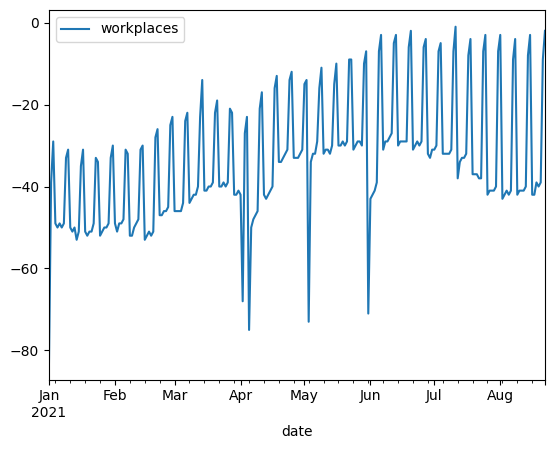

In [23]:
#create a plot of date and the retail/recreation field
mobility_uk.plot('date', 'workplaces')

Great- you should have a graph showing the date along the x-axis and the retail and recreation change on the y-axis.
It's pretty cool that Python can plot all this!
Instead of lines, we could use a symbol instead:


<Axes: xlabel='date'>

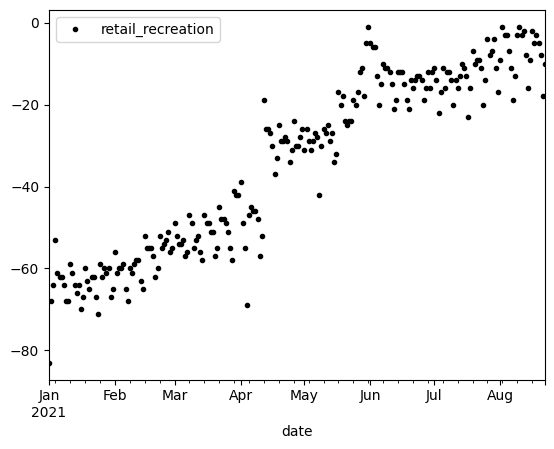

In [24]:
mobility_uk.plot('date', 'retail_recreation', style = 'k.' )

However, this does make it a bit harder to see!

We can also plot values in the same way we would non-temporal data, e.g. through histograms.

(array([ 2.,  3.,  0., 17., 37., 56., 68., 11., 13., 27.]),
 array([-83. , -74.8, -66.6, -58.4, -50.2, -42. , -33.8, -25.6, -17.4,
         -9.2,  -1. ]),
 <BarContainer object of 10 artists>)

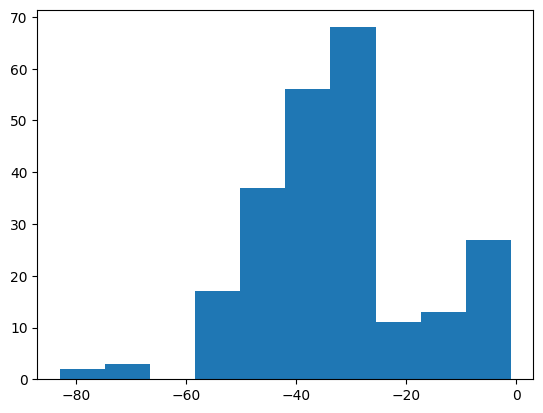

In [25]:
#create a histogram of the retail and recreation data, with an appropriate number of bins
plt.hist(mobility_uk['workplaces'])

For box plots comparing the different mobility features, we create a subset of just these columns and include them on the same axes. Create a subset of the `mobility_uk` data just with all of the mobility categories (i.e.: retail recreation, parks, workplaces, etc). We can then call a boxplot on the whole subset, by running the code below.

In [32]:
#create your subset
mobility_plots = mobility.drop(['date', 'country_region', 'sub_region_1', 'sub_region_2'], axis = 1)

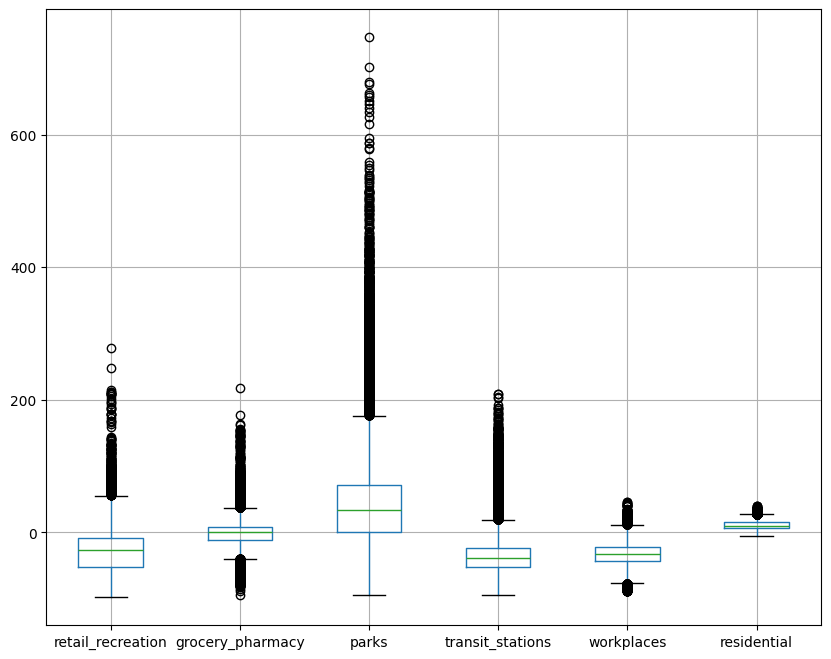

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,8), )
mobility_plots.boxplot()
plt.show()

What does this boxplot tell us about the change in mobility for the different locations?

In [ ]:
#your comments on the boxplot here

We can also create a heatmap showing the correlation (frequency of co-visits to pairs of amenities on the same day). This is similar to heatmap generation you did in previous weeks

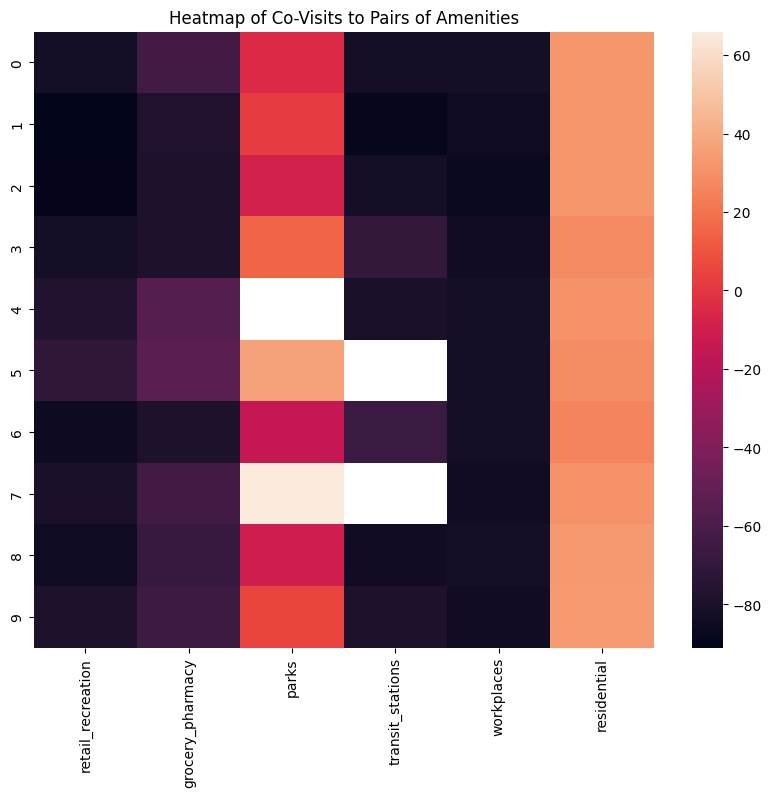

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(mobility_plots[:10])
plt.title('Heatmap of Co-Visits to Pairs of Amenities')
plt.show()

In [ ]:
#Discuss your findings from the heatmap here.


We can also use our subset to plot our time series graphs on top of each other by creating a data frame with time as well. Recalculate your `mobility_plots` subset, but this time include the date variable as well.

In [38]:
mobility_time_plots = mobility.drop(['country_region', 'sub_region_1', 'sub_region_2'], axis = 1)

<Axes: xlabel='date'>

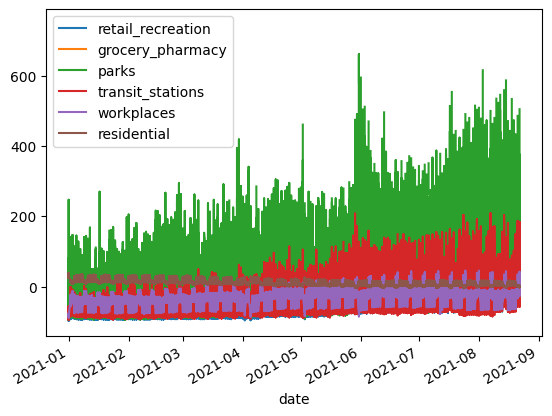

In [42]:
#plot by date again, and you should see how Python/Pandas automatically groups by the different mobility categories
mobility_time_plots.plot('date')

This is looking good! Now we've compared the different categories, we can also compare different regions. This is simplest if we pick just one variable, so we'll look at residential, which tells us how much time people have been spending in residential areas (i.e. their own homes, relative to 'normal').   Let's compare the UK average `sub_region` to a London subregion (Southwark- where the shard is), and Leeds (these are labelled in the `sub_region_2` variable).

We're going to create a new table, which will have the dates as one column, followed by the residential mobility of each region (UK, London, Leeds).

We'll first create subsets of `sub_region_2 == 'London Borough of Southwark'` and `sub_region_2 == 'Leeds District'`;  do this below.

In [43]:
mobility_london = mobility.loc[mobility['sub_region_2'] == 'London Borough of Southwark']
mobility_leeds = mobility.loc[mobility['sub_region_2'] == 'Leeds District']

We can now create our residential subsets, which include only the date and `residential` variables.

In [48]:
mobility_london_res = mobility_london[['date', 'residential']]
mobility_leeds_res = mobility_leeds[['date', 'residential']]
mobility_uk_res = mobility_uk[['date', 'residential']]

Before we join these up, we'll rename the `residential` column, so we know which area it refers to. We've done the first one for you, so add the code to rename the column for Leeds and the rest of the UK below.

In [49]:
mobility_london_res.rename(columns = {"residential": "Southwark residential"}, inplace = True)

#rename the residential columns in your Leeds and UK data
mobility_leeds_res.rename(columns = {"residential": "Leeds residential"}, inplace = True)
mobility_uk_res.rename(columns = {"residential": "UK residential"}, inplace = True)


To create our final dataset, we just need to join them all back together, based on the date column, adding each local area as a new column.

In [53]:
#first add the london data to the UK mobility data:
mobility2 = mobility_uk_res.join(mobility_london_res, on='date')

#now join Leeds to mobility2:
mobility_res = mobility2.join(mobility_leeds_res, on='date')

ValueError: You are trying to merge on datetime64[ns] and int64 columns for key 'date'. If you wish to proceed you should use pd.concat

View the final dataset to see what we've created:

In [ ]:
#look at the data

The final step is to create a comparative plot to visualise this. We can re-create our `mobility_time_plot`, but for our `mobility_res` data, to view the change over time in the different regions.

In [ ]:
#plot the mobility_res data

What patterns do you observe over time and between the different areas? Comment on this below.

In [ ]:
#comment on what you can infer from the plot


<br> <br> <br>
## Simple Moving Average
Now we've done a lot of visualising and exploring our temporal data, we'll get started on some modelling. For our moving averages, it's simplest to work with just one variable at a time, so we will use the `mobility_uk_res` subset we created in the previous section. This should be the residential mobility for the UK, without the other individual subregions.
Have a quick look at this data set to remind us what it looks like.

In [ ]:
#look at the mobility_uk_res data

We'll start by calculating different moving averages, which are good for analysing trends. This is pretty straightforward- we can specify the time period we want to calculate our average for, and add this as an additional parameter. Run the code below to calculate the 7-day moving average (i.e. the average for each 7-day period within the data), and then view the resulting addition to the data.

In [ ]:
mobility_uk_res['7 day Avg'] = mobility_uk_res['UK residential'].rolling(7, min_periods=1).mean() # 7day moving average
#can you figure out what each part of this code does?

In [ ]:
#view the data

Now, calculate the 14-day and 28-day moving averages and add these to the data frame.

In [ ]:
#calculate further moving averages

Now you should be able to plot the `mobility_uk_res` data, and examine the original data, alongside the moving averages.

In [ ]:
#plot thr mobility_uk_res data and view the different groupings

In [ ]:
#comment on how these different moving averages compare

Do you remeber that we mentioned simple moving average is not that suitable for making predictions? We can quantatively evaluate the differences between moving average values (can be seen as predictions) and actual values. We use the metrics RMSE and MAPE in this case.

You could see [here](https://medium.com/@jonatasv/metrics-evaluation-mse-rmse-mae-and-mape-317cab85a26b) for a reference of these metrics. In short, RMSE is about error values while MAPE is about mean absolute PERCENTAGE error.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Calculate the 7-day, 14-day, and 28-day moving averages using only previous days' values
# Can you find the differences here, compared to previous moving average function?
mobility_uk_res['7 day Avg shift'] = mobility_uk_res['UK residential'].shift(1).rolling(7, min_periods=1).mean()
mobility_uk_res['14 day Avg shift'] = mobility_uk_res['UK residential'].shift(1).rolling(14, min_periods=1).mean()
mobility_uk_res['28 day Avg shift'] = mobility_uk_res['UK residential'].shift(1).rolling(28, min_periods=1).mean()

# Drop rows where any of the moving averages or the actual values contain NaN
mobility_uk_res = mobility_uk_res.dropna(subset=['UK residential', '7 day Avg shift', '14 day Avg shift', '28 day Avg shift'])

# Calculate RMSE and MAPE for each moving average
rmse_7 = np.sqrt(mean_squared_error(mobility_uk_res['UK residential'], mobility_uk_res['7 day Avg shift']))
mape_7 = mean_absolute_percentage_error(mobility_uk_res['UK residential'], mobility_uk_res['7 day Avg shift'])

rmse_14 = np.sqrt(mean_squared_error(mobility_uk_res['UK residential'], mobility_uk_res['14 day Avg shift']))
mape_14 = mean_absolute_percentage_error(mobility_uk_res['UK residential'], mobility_uk_res['14 day Avg shift'])

rmse_28 = np.sqrt(mean_squared_error(mobility_uk_res['UK residential'], mobility_uk_res['28 day Avg shift']))
mape_28 = mean_absolute_percentage_error(mobility_uk_res['UK residential'], mobility_uk_res['28 day Avg shift'])

# Print the results
print(f"7-day Avg - RMSE: {rmse_7}, MAPE: {mape_7 * 100}%")
print(f"14-day Avg - RMSE: {rmse_14}, MAPE: {mape_14 * 100}%")
print(f"28-day Avg - RMSE: {rmse_28}, MAPE: {mape_28 * 100}%")


The percentage errors appear to be quite large, indicating that the simple moving average is more suited for understanding trends by smoothing out variations rather than for making accurate predictions.

One other way of calculating moving averages doesn't just use a specified time window, as above, but calculates the cumulative average based on _all_ previous values, so the average on day 2 will be the average of these 2 days, and the average on day 200 will be the average of all 200 days! We calculate this in the below cell. Then you can re-plot your time series graph, and comment on how the cumulative average compares to the previous averages.

In [ ]:
mobility_uk_res['Cumulative Avg'] = mobility_uk_res['UK residential'].expanding().mean()
#the 'expanding' tells python to increase the average window each time

In [ ]:
#plot the data again

In [ ]:
#comment on how these different moving averages compare

<br><br><br>
## Simple Exponential Smoothing

We willl now extend our moving averages to look at prediction, first using a simple exponential smoothing where we specify an _alpha_ or _smoothing function_, which determines how much we weight previous observations in our average. Higher values give greater weighting to the most recent average, and therefore smooth faster, whereas lower values give more weighting to the most recent observation, so they smooth more gradually. Let's try this out. We first need to add in some new packages.

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

Just to be a bit confusing, this package requires the data to be in an array format, rather than in a date frame. We don't need to worry about why too much, just that some packages work with data in a slightly different way because they're designed by different people, so this step just makes sure that our calculations will work.

In [ ]:
res = mobility_res['UK residential'].tolist() #turn our residential data into a list
dates = pd.DatetimeIndex(mobility_res.date) #create a datetime index
mobility_ESA = pd.Series(res, dates).asfreq('D') #join these up in an array

Now call `mobility_ESA` (for Exponential Smoothing Average) to see how this looks, compared to our previous data.

In [ ]:
#look at the data

We can still plot this, and it should look just the same:

In [ ]:
#plot the data

Great, we can now calculate our Exponential Smoothing Averages. We will start with a smoothing function of 0.1. The command might look a bit complex, but the main bit we need to focus on is the command `SimpleExpSmoothing` which calculates our model, and the `fit(smoothing_level = 0.1)` which fits the model with an _alpha_ value of 0.1. We can then plot this with our original data. See if you can follow what each step below does. If you get a warning saying `no frequency information was provided`, that's ok, as long as your code still runs! We don't need to provide the frequency, as we know our data is daily.

In [ ]:
#fit the model with a smoothing alpha of 0.1
ESAfit1 = SimpleExpSmoothing(mobility_ESA, initialization_method="heuristic").fit(smoothing_level=0.1,optimized=False)

#create a plot
plt.figure(figsize=(12, 8))

#plot the original data in grey
plt.plot(mobility_ESA,color='gray')

#add the exponentially smoothed data in blue:
plt.plot(ESAfit1.fittedvalues, color='blue')

We can also predict what will happen next, using our exponential smoothing model, and plot this on our figure!

In [ ]:
#predict for the next 30 days, based on our fitted model, and rename it alpha 0.1
fcast1 = ESAfit1.forecast(30).rename(r'$\alpha=0.1$')

#create a plot
plt.figure(figsize=(12, 8))

#plot the original data in grey
plt.plot(mobility_ESA,color='gray')

#add the exponentially smoothed data in blue:
plt.plot(ESAfit1.fittedvalues, color='blue')

#add a line with our predicted values
line1, = plt.plot(fcast1, color='blue')

#add a legend, linking line1 to the name
plt.legend([line1], [fcast1.name])

What do you notice about the prediction?

In [ ]:
#comment on the prediction

Now we can test out other values of alpha- try calculating the model and predicting for values of 0.5 and 0.9, and plot these on the same graph to see they compare. We've started the code off for you below- make sure you plot the lines in different colours so you can tell them apart!

In [ ]:
#fit the model with a smoothing alpha of 0.1
ESAfit1 = SimpleExpSmoothing(mobility_ESA, initialization_method="heuristic").fit(smoothing_level=0.1,optimized=False)

#predict for the next 30 days
fcast1 = ESAfit1.forecast(30).rename(r'$\alpha=0.1$')

#repeat with alpha of 0.5
ESAfit2 =
fcast2 =

#repeat with alpha of 0.9
ESAfit3 =
fcast3 =


plt.figure()
...

plt.plot(ESAfit1.fittedvalues, color='blue')
line1, = plt.plot(fcast1, color='blue')
plt.plot(ESAfit2...)
line2, =
plt.plot()
line3, =
plt.legend([], [])

How do these different values of _alpha_ compare, in terms of their smoothing and predictive ability?

In [ ]:
#comment here

We can also get Python to find the 'optimal' amount of smoothing for our data, so we don't specify a value for _alpha_.
Run the code below to calculate the optimal value, and then plot it, alongside the prediction, with the original data.

In [ ]:
#automatically estimates the optimal smoothing level
ESAfit4 = SimpleExpSmoothing(mobility_ESA, initialization_method="estimated").fit()
fcast4 = ESAfit4.forecast(30).rename(r'$\alpha=%s$'%ESAfit4.model.params['smoothing_level'])

In [ ]:
#plot the data
plt.figure(figsize=(12, 8))
plt.plot(mobility_ESA,color='gray')
plt.plot(ESAfit4.fittedvalues, color='green')
line4, = plt.plot(fcast4, color='green')
plt.legend([line4], [fcast4.name])

In this case, our alpha value is 0.0986 to 3 significant figures, so we'd probably round it and use 0.1. This is the value we will use when we add further parameters with Double Exponential Smoothing.

<br><br><br>
## Double Exponential Smoothing
Now we'll extend this to Double Exponential Smoothing (DES).  This section will be very similar to the Simple Exponential, but we also specify a _beta_ parameter, which allows us to incorporate trends in our data, by weighting previous observations and updating how this affects our model at each time point.


__Note:__ DES this only works on positive data, so beware if you're trying to use data with negative values- you'll get an error! You can check your data by calling `.min()` on the mobility_ESA array, the minimum value should be above 0 for it to work.

In [ ]:
mobility_ESA.min()

We'll continue with our optimised smoothing (_alpha_) value, rounded to 0.1, and experiment with different smoothing trend (_beta_) value parameters-- thankfully, it works much the same was as our SES models, above. We'll start with a smoothing trend of 0.2.

In [ ]:
#fit with optimised alpha of 0.1 and beta of 0.2
DESAfit1 = Holt(mobility_ESA, exponential=True, initialization_method="estimated").fit(smoothing_level=0.1, smoothing_trend=0.2, optimized=False)


In [ ]:
#create a plot
plt.figure(figsize=(12, 8))

#plot the original data in grey
plt.plot(mobility_ESA,color='gray')

#add the double exponentially smoothed data in blue:
plt.plot(DESAfit1.fittedvalues, color='blue')

How does this compare to our single exponential smoothed model?

In [ ]:
#comment on the model

Again, we can predict the next 30 days based on our model.

In [ ]:
#predict for the next 30 days, based on our fitted model, and rename it beta 0.2
fcast1 = DESAfit1.forecast(30).rename(r'$\beta=0.2$')

#create a plot
plt.figure(figsize=(12, 8))

#plot the original data in grey
plt.plot(mobility_ESA,color='gray')

#add the double exponentially smoothed data in blue:
plt.plot(DESAfit1.fittedvalues, color='blue')

#add a line with our predicted values
line1, = plt.plot(fcast1, color='blue')

#add a legend, linking line1 to the name
plt.legend([line1], [fcast1.name])

This should look pretty different to our previous prediction, as the prediction decreases over time, rather than staying constant.

Similarly to before, we can test out other values of beta- try calculating the model and predicting for values of 0.5 and 0.8, and plot these on the same graph to see they compare. Again, the code is started off for you.

__Hint:__ Remember to leave the `smoothing_level` alone, as we calculated that in our SES models, and just change the `smoothing_trend` parameter.

In [ ]:
#fit with optimised alpha of 0.1 and beta of 0.2
DESAfit1 = Holt(mobility_ESA, exponential=True, initialization_method="estimated").fit(smoothing_level=0.1, smoothing_trend=0.2, optimized=False)
fcast1 = DESAfit1.forecast(30).rename(r'$\beta=0.2$')
#fit with beta of 0.5
DESAfit2 =
fcast2 =
#fit with beta of 0.8
DESAfit3 =
fcast3 =


plt.figure(figsize=(12, 8))
plt.plot...

Which value of _beta_ looks best to you? Why is this?

In [ ]:
#comment on the plot here

<br><br><br>
## Triple Exponential Smoothing
Now we'll further extend this to Triple Exponential Smoothing (TES), namely the Holt-Winter's seasonal method. With the method, we will explore the effect of modelling seasonality. Similar to the previous two sections of Simple/Double Exponential, but we also specify all of the $\alpha$, $\beta$ and $\gamma$ parameters, which allows us to consider level, trends, and seasonality in our data.


__Note:__ TES also only works on positive data.

We'll start with a smoothing level 0.1 smoothing seasonal of 0.2 (as in Double Exponential). In addition, naturally we will use the seasonal periods of 7, to capture the weekly variance.


In [ ]:
# fit with optimised alpha of 0.1 and beta of 0.2, and a gamma 0.5 for test
TESfit1 = ExponentialSmoothing(mobility_ESA, trend='add', seasonal='add', seasonal_periods=7, initialization_method='estimated').fit(smoothing_level=0.1, smoothing_trend=0.2, smoothing_seasonal=0.5, optimized=False)

In [ ]:
#create a plot
plt.figure(figsize=(12, 8))

#plot the original data in grey
plt.plot(mobility_ESA,color='gray')

#add the double exponentially smoothed data in blue:
plt.plot(TESfit1.fittedvalues, color='blue')

Do you see that the predictions now make much more sense? This is because the original time series dataset has a prominent weekly variation pattern, and we really need to capture this weekly pattern in order to make good predictions.

In [ ]:
# comment on the results

Again, we can predict the next 30 days based on our model.


In [ ]:
#predict for the next 30 days, based on our fitted model, and rename it gamma 0.5
fcast1 = TESfit1.forecast(30).rename(r'$\gamma=0.5$')

#create a plot


#plot the original data in grey

#add the double exponentially smoothed data in blue:

#add a line with our predicted values

#add a legend, linking line1 to the name

Now the future predictions make much more sense.

Of course, we can do similar tests like before, to test different $\gamma$ values and plot the predictions. But here we will evaluate the performance of different $\gamma$ values in a different way, say, quantitatively.

Let's derive RMSE and MAPE for different values of $\gamma$, from 0.01 to 1, with the interval of 0.01, so 100 options in total.

This can be done in a loop in which you store the smallest errors.


In [ ]:
# Initialize variables to store the best smoothing_seasonal value and its errors
best_smoothing_seasonal = 0
min_rmse = float('inf')
min_mape = float('inf')

# update the three above variables in a loop
for smoothing_seasonal in np.arange(0.01, 1.01, 0.01):

    # Fit the Triple Exponential Smoothing model

    # Make predictions
    predictions = TESfit.fittedvalues

    # Calculate RMSE and MAPE


    # Update best_smoothing_seasonal if current value results in lower errors for both


# Print the best smoothing_seasonal value and its corresponding errors
print(f"Best smoothing_seasonal: {best_smoothing_seasonal}")
print(f"Minimum RMSE: {min_rmse}")
print(f"Minimum MAPE: {min_mape}")

Let's now plot the predictions with the best smoothing_seasonal parameter found.

In [ ]:
TESfit_best = ExponentialSmoothing(mobility_ESA, trend='add', seasonal='add', seasonal_periods=7, initialization_method='estimated').fit(smoothing_level=0.1, smoothing_trend=0.2, smoothing_seasonal=best_smoothing_seasonal, optimized=False)
#predict for the next 30 days, based on our fitted model, and rename it best gamma
fcast1 = TESfit_best.forecast(30).rename(r'best $\gamma$')

#create a plot

#plot the original data in grey

#add the double exponentially smoothed data in blue:

#add a line with our predicted values


#add a legend, linking line1 to the name


<br><br><br>
## Interrupted Time Series
Finally, we move onto Interrupted Time Series (ITS) Analysis, which allows us to model how a trend has changed before and after a certain date. As we have data for 2021, it covers some of the Covid-19 lockdowns, so we will start by looking at what happened to mobility before and after 17th May, the date most restrictions were lifted in England. As the busiest area in the country, we will continue focussing on London.

Read more about the different lockdown dates (if you can handle more information on Covid) [here](https://www.gov.uk/government/publications/covid-19-response-spring-2021/covid-19-response-spring-2021-summary).

We first import our new packages, as then create a plot where we will add a vertical line, so we can visualise the time point for our before-and-after model.

In [ ]:
import statsmodels.api as sm #add statsmodels
from statsmodels.sandbox.regression.predstd import wls_prediction_std #allow us to predict

In [ ]:
fit = mobility_london.plot('date', figsize = (10,8))
plt.axvline(pd.to_datetime('2021-05-17'), -5, 40, color = 'red')

Looking at the graph, it appears that there may be a change in the use of transit after the 17th May, so we will start by plotting just that graph. Create the plot below, and add in the vertical line.

In [ ]:
#create the plot of transit stations over time, and add the vertial line

As you should remember from the lecture notes, in order to calulate an ITS model, we need a couple more variables: _t_, which is the days elapsed since the start of the data, _x_ which tells us whether we are before or after the intervention, and _xt_, which indicates the number of days elapsed since the intervention.

We'll start by adding a time variable, which counts the time since the start of the data. As our data is in order of date, this is equivalent to the length of the data at each row. Then view the head of the data to check it has worked.

In [ ]:
mobility_london['time'] = np.arange(len(mobility_london))

In [ ]:
#view the head of the data

Now, in order to add a variable _x_ with value 0 (before intervention) and 1 (after intervention) we need to check the time index on our intervention date,  the 17th May 2021.

In [ ]:
#find the row where the date is the 17th May 2021, and check what the value of the 'time' variable is:

Now add two new columns, one where we'll add a binary for before/after the intervention, and another for time since the intervention. Add the value of the time variable (i.e. the time elapsed since the first measurement) you found for the date of May 17th to the code below. We'll call this column `intervention`, and then multiply this by our `time` variable, and subtract the time elapsed before the intervetion, to calculate the time elapsed since the intevention (the equivalent of _xt_), which we'll call `i_time`.
This means we'll end up counting from 1 for the time since intervention.

In [ ]:
#mobility_london['intervention'] = np.where(mobility_london['time'] >= #add the time you found here, 1, 0)


In [ ]:
mobility_london['i_time'] = np.where(mobility_london['intervention']== 1, ((mobility_london['time']*mobility_london['intervention'])-136), 0)
#new variable called 'i_time', if the intervention has happened, calculate the time since the intervention
#ie (time x intervention) - time since intervention
#if the intervention hasn't happened, set the value to 0

Now view the data and examine the three new variables we've created in this section:

In [ ]:
#view the data

Now we have our dataset, we can use linear regression, with the equation: <br>
_expected residential mobility = B1*time + B2*intervention + B3*i_time + constant + e_

This allows us to calculate the difference in the trend (i.e. the relationship between time and our data), before and after our intervention. Build a linear regression model using the instructions below. __Hint:__ It might be helpful to look back at Week 4, where we first used linear regression.

In [ ]:
#the y variable is the mobility at transit stations

#the X variables are time, whether or not the intervention has happened, and time since the intervention

#add a constant to X

#create an OLS regression model

#fit the model

#print the results

What do these results mean?

We should be able to see positive association between time, intervention, and mobility at transit stations, which means that as time increases, mobility at transit stations also increases, and that the increase continues after the intervention. <br>
However, we also have a negative association between the time since intervention and mobility, which shows that the strength of increase drops after the intervention.<br>

How does this interpretation relate to what you can observe in the graph you plotted?

## Further Reading
If you are interested, you could try to look up online how machine learning methods are used for time series forecasting, e.g. [this Kaggle link](https://www.kaggle.com/code/namanmanchanda/rnn-in-pytorch).

Please bear in mind that deep learning uses specific Python libraries (Pytorch in this case), and has specific ways of loading data, model, and computing, e.g. in GPUs. This is a big topic so please don't feel discouraged if the terms and techniques do not make sense for you yet. If you're interested, a good starter is to find an online course about deep learning introduction.

## Formative Homework Questions

Well done, you have made it to the end of the lab!

As an extension exercise, please answer the following formative questions:

__Question 1:__ In Leeds, which pair of amenities has the highest level of positive correlation (which could be reflected from a heatmap of correlations.

__Question 2:__ In Manchester (sub_region_2 == 'Manchester') and for the amenity 'retail_recreation', what is the best _alpha_ value leading to the smallest RMSE, in simple exponential smoothing. Please search from 0.0 to 1.0, with 0.01 as the interval.

__Question 3:__ In Manchester and for the amenity 'workplaces', and using triple exponential smoothing with 7 as the period of smoothing, what is the MAPE if you let the function search for the best parameters.
<br>

